# Phase 2: Bi-LSTM Text Classifier (Pure PyTorch)

- Dataset: AG News
- Model: Embedding → Bi-LSTM → FC
- Framework: PyTorch (CPU)
- No torchtext (manual NLP pipeline)


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
data_path = "../data/AG_news/train.csv"

df = pd.read_csv(
    data_path,
    header=None,
    names=["label", "title", "description"]
)

df.head()


,label,title,description
0,Class Index,Title,Description
1,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
2,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
3,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
4,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...


In [4]:
# Read CSV with header
df = pd.read_csv(data_path)
df = df.rename(columns={"Class Index": "label", "Title": "title", "Description": "description"})

# Combine title + description
df["text"] = df["title"] + " " + df["description"]

# Convert labels to integers 0-3
df["label"] = df["label"].astype(int) - 1

# Keep only text and label
df = df[["text", "label"]]
df.head()


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


In [6]:
def tokenize(text):
    return text.lower().split()


In [7]:
from collections import Counter

counter = Counter()

for text in X_train:
    counter.update(tokenize(text))

vocab = {
    "<PAD>": 0,
    "<UNK>": 1
}

for word in counter:
    vocab[word] = len(vocab)

vocab_size = len(vocab)
vocab_size


141023

In [8]:
def encode(text, vocab):
    return torch.tensor(
        [vocab.get(word, vocab["<UNK>"]) for word in tokenize(text)],
        dtype=torch.long
    )


In [9]:
encode("apple launches unknownword", vocab)


tensor([1310, 4155,    1])

In [10]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return encode(self.texts[idx], self.vocab), self.labels[idx]


In [11]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return texts_padded, labels


In [12]:
batch_size = 64

train_dataset = NewsDataset(X_train, y_train, vocab)
val_dataset = NewsDataset(X_val, y_val, vocab)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)


In [13]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)

        # Concatenate forward & backward hidden states
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        return self.fc(hidden)


In [14]:
model = BiLSTMClassifier(
    vocab_size=vocab_size,
    embed_dim=128,
    hidden_dim=128,
    num_classes=4
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [15]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")


Epoch 1/5 - Loss: 810.1669
Epoch 2/5 - Loss: 382.1991
Epoch 3/5 - Loss: 250.0862
Epoch 4/5 - Loss: 164.0975
Epoch 5/5 - Loss: 114.7596


In [16]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels in val_loader:
        texts = texts.to(device)
        outputs = model(texts)
        preds = torch.argmax(outputs, dim=1).cpu()

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())


In [17]:
acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

acc, cm


(0.9030833333333333,
 array([[5480,  132,  235,  153],
        [ 157, 5728,   77,   38],
        [ 236,   50, 5308,  406],
        [ 249,   66,  527, 5158]]))

In [18]:
# Make sure model is in evaluation mode
model.eval()

all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for texts, labels in val_loader:
        texts = texts.to(device)
        outputs = model(texts)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_val_preds.extend(preds.numpy())
        all_val_labels.extend(labels.numpy())


In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy
acc = accuracy_score(all_val_labels, all_val_preds)
print(f"Validation Accuracy: {acc:.4f}")

# Precision, Recall, F1
labels_names = ["World", "Sports", "Business", "Sci/Tech"]
report = classification_report(all_val_labels, all_val_preds, target_names=labels_names)
print(report)


Validation Accuracy: 0.9031
              precision    recall  f1-score   support

       World       0.90      0.91      0.90      6000
      Sports       0.96      0.95      0.96      6000
    Business       0.86      0.88      0.87      6000
    Sci/Tech       0.90      0.86      0.88      6000

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000



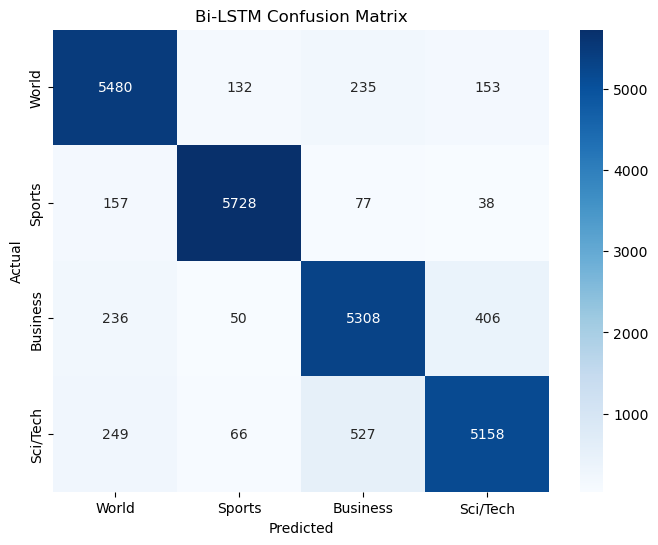

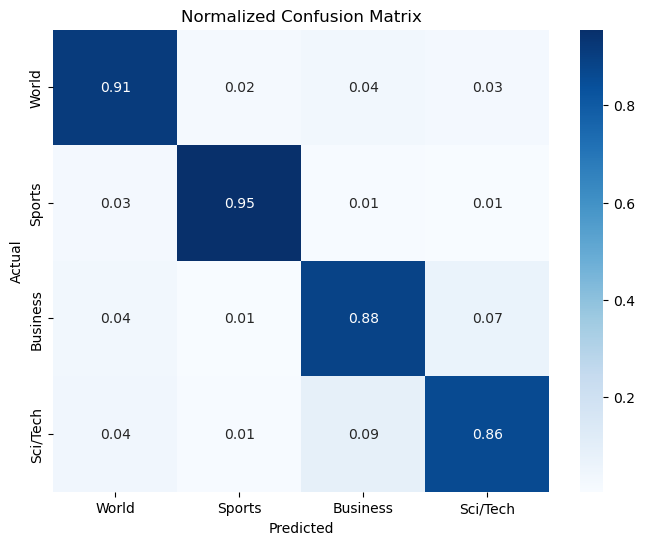

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Raw Confusion Matrix
cm = confusion_matrix(all_val_labels, all_val_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_names,
            yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Bi-LSTM Confusion Matrix")
plt.savefig('../results/confusion_matrix_bilstm.png')
plt.show()

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_names,
            yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.savefig('../results/confusion_matrix_norm_bilstm.png')
plt.show()
